In [1]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [2]:
# For SVR and GBRT Models
def window_dataset(series, window_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))    
    #dataset = dataset.shuffle(shuffle_buffer)                                   
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))             
    #dataset = dataset.batch(batch_size).prefetch(1)
    #dataset = dataset.prefetch(1)
    dataset = list(dataset) 
    x_train_dataset = []
    y_train_dataset = []

    for series in dataset:
        x_train_dataset.append(series[0])
        y_train_dataset.append(series[1])    
        
    x_train_dataset = np.array(x_train_dataset)
    y_train_dataset = np.array(y_train_dataset)
          
    return x_train_dataset, y_train_dataset

In [235]:
def get_window_dataset(series, window_size):
    srslen = len(series)
    #series = np.expand_dims(series, axis=-1)
    head, tail = 0, window_size
    windowed_dataset = []
    #print(series[tail,np.newaxis])#,:np.newaxis])
    while tail<srslen:
        windowed_dataset.append([series[head:tail], series[tail]])
        head+=1
        tail=head+window_size
    
    return windowed_dataset

In [290]:
def split_fn(chunk):
    """to split the dataset sequences into input and targets sequences"""
    inputs = []
    targets = []
    for xy in chunk:
        inputs.append(xy[0])
        targets.append(xy[1])      
        #inputs = np.concatenate((inputs, xy[0]), axis=0)
        #targets = np.concatenate((targets, xy[1]), axis=0)

    inputs = torch.tensor(np.array(inputs), device=device)
    targets = torch.tensor(np.array(targets), device=device)
    
    return inputs, targets

In [291]:
def test_data_to_dataset(test_data, window_size=10, batch_size=15):
    test_window = get_window_dataset(test_data, window_size)

    x_test, y_test = split_fn(test_window)
    test_dataset = torch.utils.data.TensorDataset(x_test[:,:,np.newaxis], y_test[:,np.newaxis])

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return test_loader

# **Tier-1 Hexagonal Cell**

In [237]:
import warnings
warnings.filterwarnings("ignore")

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import time
import pickle

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

import torch
import torch.nn as nn
import torch.nn.functional as F

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from hmmlearn import hmm
warnings.filterwarnings("ignore", category=DeprecationWarning)

keras = tf.keras

In [239]:
from utils import *
from Network import *

In [294]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [240]:
# # monkey patch around bug in ARIMA class
# def __getnewargs__(self):
# 	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
# ARIMA.__getnewargs__ = __getnewargs__

In [241]:
radius = 500

t = np.linspace(0, 2*math.pi, 7)

#center cell
x1 = []
y1 = []
for i in range(len(t)):
  x1.append(0 + radius*math.cos(t[i]))
  y1.append(0 + radius*math.sin(t[i]))

c_x1 = 0  #BS Location Center Cell x-axis
c_y1 = 0 #BS Location Center Cell y-axis


#upper cell
x2 = []
y2 = []
for i in range(len(t)):
  x2.append(0+radius*math.cos(t[i]))
  y2.append(((math.sqrt(3)/2)*2*radius) + (radius*math.sin(t[i])))

c_x2 = 0  #BS Location Upper Cell x-axis
c_y2 = ((math.sqrt(3)/2)*2*radius) #BS Location Upper Cell y-axis


#lower cell
x3 = []
y3 = []
for i in range(len(t)):
  x3.append(0+radius*math.cos(t[i]))
  y3.append(-((math.sqrt(3)/2)*2*radius) + (radius*math.sin(t[i])))

c_x3 = 0  #BS Location Lower Cell x-axis
c_y3 = -((math.sqrt(3)/2)*2*radius) #BS Location Lower Cell y-axis


#right upper cell
x4 = []
y4 = []
for i in range(len(t)):
  x4.append((radius+(radius/2)) + radius*math.cos(t[i]))
  y4.append(((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x4 = (radius+(radius/2))  #BS Location right upper Cell x-axis
c_y4 = ((math.sqrt(3)/2)*radius) #BS Location right upper Cell y-axis


#%Right Lower cell
x5 = []
y5 = []
for i in range(len(t)):
  x5.append((radius+(radius/2)) + radius*math.cos(t[i]))
  y5.append(-((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x5 = (radius+(radius/2))  #BS Location right lower Cell x-axis
c_y5 = -((math.sqrt(3)/2)*radius) #BS Location right lower Cell y-axis


#%Left Upper cell
x6 = []
y6 = []
for i in range(len(t)):
  x6.append(-(radius+(radius/2)) + radius*math.cos(t[i]))
  y6.append(((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x6 = -(radius+(radius/2))  #BS Location Left upper x-axis
c_y6 = ((math.sqrt(3)/2)*radius) #BS Location Left upper y-axis


#left lower cell
x7 = []
y7 = []
for i in range(len(t)):
  x7.append(-(radius+(radius/2)) + radius*math.cos(t[i]))
  y7.append(-((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x7 = -(radius+(radius/2)) #BS Location left lower Cell x-axis
c_y7 = -((math.sqrt(3)/2)*radius) #BS Location left lower Cell y-axis


BS_locations_x = [c_x1, c_x2, c_x3, c_x4, c_x5, c_x6, c_x7]    #centre, up, low, right up, right low, left up, left low
BS_locations_y = [c_y1, c_y2, c_y3, c_y4, c_y5, c_y6, c_y7]

X =np.array([x1,x2,x3,x4,x5,x6,x7])
Y =np.array([y1,y2,y3,y4,y5,y6,y7])

diff = [c_x4, c_y4] 
ISD = np.linalg.norm(diff)
print("ISD: ", ISD)

ISD:  866.0254037844386


[-1500, -1500, -1500, -750.0, -750.0, -2250.0, -2250.0]
[1732.0508075688772, 2598.0762113533156, 866.0254037844386, 2165.0635094610966, 1299.0381056766578, 2165.0635094610966, 1299.0381056766578]


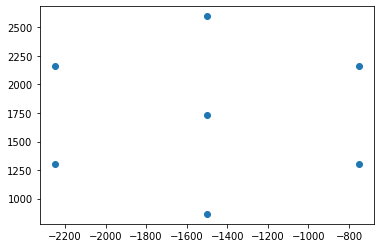

In [242]:
# ISD = sqrt(3)*RADIUS
isd = math.sqrt(3)*radius
BS2x = [x + (-3*radius) for x in BS_locations_x]
BS2y = [y + (2*isd) for y in BS_locations_y]

print(BS2x)
print(BS2y)
plt.scatter(BS2x, BS2y)
plt.show()

In [243]:
BS3x = [x + (1.5*radius) for x in BS_locations_x]
BS3y = [y + (2.5*isd) for y in BS_locations_y]

In [244]:
BS4x = [x + (4.5*radius) for x in BS_locations_x]
BS4y = [y + (0.5*isd) for y in BS_locations_y]

In [245]:
BS5x = [x + (3*radius) for x in BS_locations_x]
BS5y = [y + (-2*isd) for y in BS_locations_y]

In [246]:
BS6x = [x + (-1.5*radius) for x in BS_locations_x]
BS6y = [y + (-2.5*isd) for y in BS_locations_y]

In [247]:
BS7x = [x + (-4.5*radius) for x in BS_locations_x]
BS7y = [y + (-0.5*isd) for y in BS_locations_y]

In [248]:
BS_total_x = [BS_locations_x, BS2x, BS3x, BS4x, BS5x, BS6x, BS7x]
#print(BS_total_x)
BS_wrap_around_x = sum(BS_total_x, [])
print(BS_wrap_around_x)
print(np.shape(BS_wrap_around_x))

BS_total_y = [BS_locations_y, BS2y, BS3y, BS4y, BS5y, BS6y, BS7y]
BS_wrap_around_y = sum(BS_total_y, [])

[0, 0, 0, 750.0, 750.0, -750.0, -750.0, -1500, -1500, -1500, -750.0, -750.0, -2250.0, -2250.0, 750.0, 750.0, 750.0, 1500.0, 1500.0, 0.0, 0.0, 2250.0, 2250.0, 2250.0, 3000.0, 3000.0, 1500.0, 1500.0, 1500, 1500, 1500, 2250.0, 2250.0, 750.0, 750.0, -750.0, -750.0, -750.0, 0.0, 0.0, -1500.0, -1500.0, -2250.0, -2250.0, -2250.0, -1500.0, -1500.0, -3000.0, -3000.0]
(49,)


**x co-ordinates of Base Stations(all wrap around + sectors)**


In [249]:
BS_wrap_around_total3x = []
for i in BS_wrap_around_x:
  for j in range(3):
    BS_wrap_around_total3x.append(i)

print(BS_wrap_around_total3x,"\n", len(BS_wrap_around_total3x))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1500.0, -1500.0, -1500.0, -1500.0, -1500.0, -1500.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -1500.0, -1500.0, -1500.0, 

**y co-ordinates of Base Stations(all wrap around+sectors)**




In [250]:
BS_wrap_around_total3y = []
for i in BS_wrap_around_y:
  for j in range(3):
    BS_wrap_around_total3y.append(i)

print(BS_wrap_around_total3y,"\n", len(BS_wrap_around_total3y))

[0, 0, 0, 866.0254037844386, 866.0254037844386, 866.0254037844386, -866.0254037844386, -866.0254037844386, -866.0254037844386, 433.0127018922193, 433.0127018922193, 433.0127018922193, -433.0127018922193, -433.0127018922193, -433.0127018922193, 433.0127018922193, 433.0127018922193, 433.0127018922193, -433.0127018922193, -433.0127018922193, -433.0127018922193, 1732.0508075688772, 1732.0508075688772, 1732.0508075688772, 2598.0762113533156, 2598.0762113533156, 2598.0762113533156, 866.0254037844386, 866.0254037844386, 866.0254037844386, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 1299.0381056766578, 1299.0381056766578, 1299.0381056766578, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 1299.0381056766578, 1299.0381056766578, 1299.0381056766578, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 3031.088913245535, 3031.088913245535, 3031.088913245535, 1299.038105676658, 1299.038105676658, 1299.038105676658, 2598.076211353316, 2598.076211353316, 2598.07621

In [251]:
BS_cor_x = np.array(BS_wrap_around_total3x)
print(BS_cor_x.shape)

BS_cor_y = np.array(BS_wrap_around_total3y)
print(BS_cor_y.shape)

(147,)
(147,)


# Function to generate(nums) amount of users in each sector

In [252]:
def GetSecusers(nums):
  
  xy_all = np.zeros((3*nums, 2))
  for j in range(7):
    count = 0
    m = 0
    p2 = np.zeros((nums,2)) 
    hk = np.array([BS_locations_x[j],BS_locations_y[j]])

    while(count<3):
      a = np.array([X[j, 0+m] - BS_locations_x[j], Y[j, 0+m] - BS_locations_y[j]])
      b = np.array([X[j, 2+m] - BS_locations_x[j], Y[j, 2+m] - BS_locations_y[j]])
      p = []
      for i in range(nums):
        u1 = np.random.uniform(0,1)                
        u2 = np.random.uniform(0,1)  
        p.append(u1*a + u2*b)
      p = np.array(p+hk)
      angle_cord= p - hk
      angles = np.arctan2(angle_cord[:,1], angle_cord[:,0])  #np.arctan2(y, x)


      if(count==0):
        p2 = p
        angles2 = angles
      else:
        p2 = np.concatenate((p2, p),axis=0)
        angles2 = np.concatenate((angles2, angles),axis=0)
      m+=2
      count+=1

    #CLUB ALL Base station users
    if(j==0):
      xy_all = p2
      angles_all = angles2
    else:
      xy_all = np.concatenate((xy_all, p2), axis=0)
      angles_all = np.concatenate((angles_all, angles2),axis=0)  

  n_users, nu = np.shape(xy_all)
  #print(np.shape(xy_all))
  #print(n_users)

  return n_users, xy_all[:,0], xy_all[:,1]
    

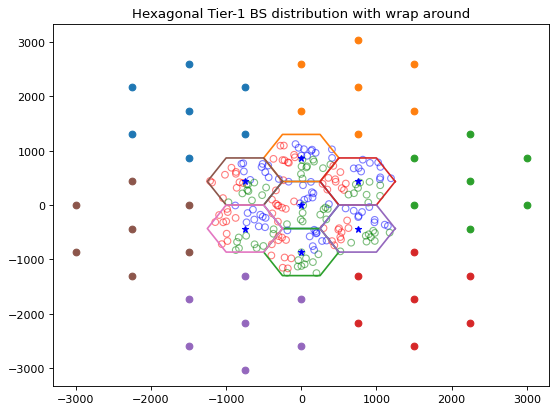

In [253]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


numm = 10
total_user, xs, ys= GetSecusers(numm)
plt.plot(x1,y1)
plt.plot(x2,y2)                                                                 
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(BS_locations_x,BS_locations_y,'b*')    

plt.scatter(BS2x, BS2y)
plt.scatter(BS3x, BS3y)
plt.scatter(BS4x, BS4y)
plt.scatter(BS5x, BS5y)
plt.scatter(BS6x, BS6y)
plt.scatter(BS7x, BS7y)

plt.title('Hexagonal Tier-1 BS distribution with wrap around')
                                                                                
for i in range(7):
  k =(3*numm)*i
  plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)


plt.show()

In [254]:
def PlotSecUsers(n_users, xs, ys):
  
  plt.plot(x1,y1)   #x,x2,x3,...,x7 are hex cell boundary         
  plt.plot(x2,y2)              
  plt.plot(x3,y3)
  plt.plot(x4,y4)
  plt.plot(x5,y5)
  plt.plot(x6,y6)
  plt.plot(x7,y7)
  plt.plot(BS_locations_x,BS_locations_y,'r*')
  plt.title('Hexagonal Tier-1 BS distribution')
  plt.xlabel('x')
  plt.ylabel('y')

  numm = int (n_users/21)

  for i in range(7):
    k =(3*numm)*i
    plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
    plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
    plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)



## **Mobility of users**

In [255]:
#Random Waypoint Model

def User_Mobility(total_user, xs, ys, v_min, v_max, Time_instants):

  # range of x and y coordinates for user mobility
  x_min = -2.25*radius
  x_max = 2.25*radius

  y_min = -1.5*isd
  y_max = 1.5*isd


  # position matrices
  x_pos = np.zeros((total_user, Time_instants))
  y_pos = np.zeros((total_user, Time_instants))

  

  # Choose velocity uniformly between v_min and v_max
  velocity = np.random.randint(v_min, v_max, (total_user))#, Time_instants)) #m/sec  #total_users x Time_instants
  #print(np.shape(velocity))

  for i in range(total_user):

    x_previous = xs[i]
    y_previous = ys[i]



    # User starts from initial position to a final position
    x_pos[i,0] = xs[i]
    y_pos[i,0] = ys[i]


    for t in range(1,Time_instants):

      #directions of the mobile users
      theta = np.random.randint(0,360)

      x_pos[i,t] = x_previous + velocity[i]* math.cos(math.radians(theta))

      if x_pos[i,t]>x_max or x_pos[i,t]<x_min:
        theta = 180 - theta
        x_pos[i,t] = x_previous + velocity[i]* math.cos(math.radians(theta))

      y_pos[i,t] = y_previous + velocity[i]* math.sin(math.radians(theta))

      if y_pos[i,t]>y_max or y_pos[i,t]<y_min:
        theta = 180 - theta
        y_pos[i,t] = y_previous + velocity[i]* math.sin(math.radians(theta))

      # Now the current position of the users becomes the previous position for next time instant
      x_previous = x_pos[i,t]
      y_previous = y_pos[i,t]

    
  x_mobile = np.transpose(x_pos) #time_instants x total_users
  y_mobile = np.transpose(y_pos)

  velocity_users = np.transpose(velocity)
  
  return x_mobile, y_mobile, velocity_users


(105,)


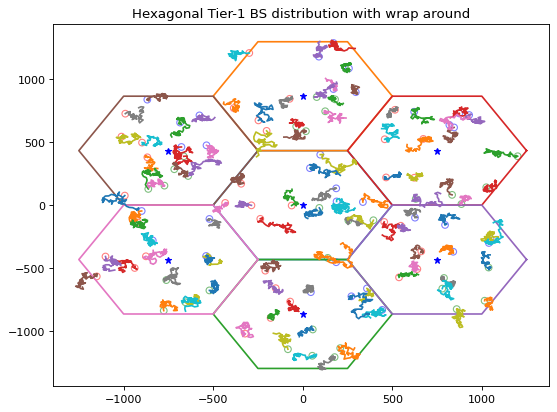

In [256]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


numm = 5
total_user, xs, ys= GetSecusers(numm)

XX, YY, vel_user = User_Mobility(total_user, xs, ys, 10, 20, 50)
print(np.shape(vel_user))

plt.plot(x1,y1)
plt.plot(x2,y2)                                                                 
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(BS_locations_x,BS_locations_y,'b*')    

#plt.scatter(BS2x, BS2y)
#plt.scatter(BS3x, BS3y)
#plt.scatter(BS4x, BS4y)
#plt.scatter(BS5x, BS5y)
#plt.scatter(BS6x, BS6y)
#plt.scatter(BS7x, BS7y)

plt.title('Hexagonal Tier-1 BS distribution with wrap around')
                                                                                
for i in range(7):
  k =(3*numm)*i
  plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)


for i in range(total_user):
  plt.plot(XX[:,i], YY[:,i])

plt.show()

# **Path Loss RMA Scenario**

In [257]:
#PL model for RMA scenario

def PathlossRMA(d_2d, d_3d):
  f_c = 2.3 #GHz
  c = 3*pow(10,8) #m/s

  h_ut = 1.5 #m
  h_bs = 35 #m
  h = 5 #m --avg. building height
  W = 20 #m --avg. street width

  d_bp = 2*math.pi*h_bs*h_ut*f_c*pow(10,9)/c

  #LOS probability
  if d_2d <= 10:
    P_los = 1
  else:
    P_los = math.exp(-1*(d_2d-10)/1000)
    
  PL_1 = 20*math.log(40*math.pi*d_3d*f_c/3 , 10) + min(0.03*pow(h, 1.72) , 10)*math.log(d_3d, 10) - min(0.044*pow(h, 1.72) , 14.77) + 0.002*math.log10(h)*d_3d
  PL_2 = PL_1*d_bp + 40*math.log10(d_3d/d_bp)

  #NLOS
  #PL_NLOS = 161.04 - 7.1*math.log10(W) +7.5*math.log10(h) - (24.37-3.7*pow(h/h_bs, 2))*math.log10(h_bs) + (43.42-3.1*math.log10(h_bs))*(math.log10(d_3d)-3) + 20*math.log10(f_c) - (3.2*pow(math.log10(11.75*h_ut) , 2) - 4.97)
  PL_NLOS = 0

  #LOS for prob>0.5
  if P_los >= 0.5:
    if d_2d <= d_bp:
      return PL_1
    elif d_2d > d_bp and d_2d < 10*1000:
      return PL_2

  else: #NLOS for prob<0.5
    if d_2d <= d_bp:
      return max(PL_1, PL_NLOS)
    elif d_2d > d_bp and d_2d < 5000:
      return max(PL_2, PL_NLOS)



# **Path Loss UMA Scenario**

In [258]:
f_c = 2.3 #GHz
c = 3*pow(10,8) #m/s

In [259]:
#PL model for UMA scenario

def PathlossUMA(d_2d, d_3d):
  f_c = 2.3 #GHz
  c = 3*pow(10,8) #m/s
  h_ut = 1.5 #m
  h_bs = 25 #m
  h_e = 1
  h_bs_eff = h_bs - h_e
  h_ut_eff = h_ut - h_e

  d_bp_eff = 4*h_bs_eff*h_ut_eff*f_c*pow(10,9)/c

  #LOS probability
  #for outdoor users
  if d_2d <= 18:
    P_los = 1
  else:
    if h_ut <= 13:
      C_h = 0
    else:
      C_h = pow((h_ut - 13)/10, 1.5)
    
    temp1 = (math.exp(-1*d_2d/63))*(1 - 18/d_2d)
    #temp2 = 1 + C_h*(5/4)*pow(d_2d/100, 3)*math.exp(-d_2d/150)
    temp2 = 1
    P_los = (18/d_2d + temp1)*temp2
    #print(P_los)

  #print(P_los)
  PL_1 = 28 + 22*math.log(d_3d, 10) + 20*math.log(f_c, 10)
  PL_2 = 28 + 40*math.log(d_3d, 10) + 20*math.log(f_c, 10) - 9*math.log(pow(d_bp_eff, 2) + pow(h_bs - h_ut, 2) , 10)
  #PL_NLOS = 13.54 + 39.08*math.log(d_3d, 10) + 20*math.log(f_c, 10) - 0.6*(h_ut - 1.5)
  PL_NLOS = 0

  #LOS for prob>0.5
  if P_los >= 0.5:
    if d_2d <= d_bp_eff:
      return PL_1
    elif d_2d > d_bp_eff and d_2d < 5000:
      return PL_2

  else: #NLOS for prob<0.5
    if d_2d <= d_bp_eff:
      return max(PL_1, PL_NLOS)
    elif d_2d > d_bp_eff and d_2d < 5000:
      return max(PL_2, PL_NLOS)

# Distance Calculations

In [260]:
def getdist(n_users,x,y, time_instants):
  h_bs = 25 #m
  h_ut = 1.5 #m
  h = 5 #avg building height
  h_act = h_bs - h_ut #m

  #distance from each user to base station
  Dr_2d = np.zeros((time_instants, 7*7*3, n_users))

  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        Dr_2d[t][i][j] = math.sqrt(pow(BS_wrap_around_total3x[i] - x[t][j], 2) + pow(BS_wrap_around_total3y[i] - y[t][j], 2)) 

  Dr_3d = np.zeros((time_instants, 7*7*3, n_users))

  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        Dr_3d[t][i][j] = math.sqrt(pow(Dr_2d[t][i][j], 2) + pow(h_act, 2))

  return Dr_2d, Dr_3d

# Path Loss Matrix

In [261]:
def PathLoss(dist2d, dist3d, n_users):
  Dr_2d, Dr_3d = dist2d, dist3d
  
  PLr = np.zeros(np.shape(Dr_2d))

  time_instants, row, col = np.shape(Dr_2d)

  #path loss calculation
  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        #PLr[t][i][j] = PathlossRMA(Dr_2d[t][i][j], Dr_3d[t][i][j])   #for RMA
        PLr[t][i][j] = PathlossUMA(Dr_2d[t][i][j], Dr_3d[t][i][j])   #for UMA
  
  return PLr


In [262]:
def PathLossWrapped(pathloss1):
  time_instant, basest, numusers = np.shape(pathloss1)

  pathloss_wrap = np.zeros((time_instant, basest*3, numusers))

  for t in range(time_instant):
    for i in range(basest):
      if(i==0):
        j = i
      pathloss_wrap[t][j] = np.copy(pathloss1[t][i])
      pathloss_wrap[t][j+1] = np.copy(pathloss1[t][i])
      pathloss_wrap[t][j+2] = np.copy(pathloss1[t][i])
      j = i+3

  return pathloss_wrap

# Log Normal Shadowing

In [263]:
def LogNormShadow(PLr): 
  X = np.random.normal(0,4, np.shape(PLr))  #shape of path loss matrix   #sigma in dB
  log_norm_loss = 1*X  #dB 

  #print(log_norm_loss)
  
  return log_norm_loss

# Correlated Shadowing

In [264]:
BS_cords = np.concatenate((BS_total_x, BS_total_y), axis=0)
BS_cords = BS_cords.reshape(2, -1) 

print(BS_cords.shape)
#print(BS_cords)

(2, 49)


In [265]:
def correlated_shadowing(x_mobile, y_mobile, sigma_shd):
    bs_wrap = 49
    D_cor = 100
    #sigma_shd = 100 #dB
    
    Dist_bs = np.zeros((bs_wrap, bs_wrap))
    Corr_bs = np.zeros(np.shape(Dist_bs))
    
    time_steps, num_users = np.shape(x_mobile)
    
    #shadowing matrix dim -> time_steps x base_stations x total_users
    shadowing_mat = np.zeros((time_steps, 147, num_users))

    for m1 in range(bs_wrap):
        for m2 in range(bs_wrap):
            Dist_bs[m1][m2] = np.linalg.norm(BS_cords[:, m1] - BS_cords[:, m2])
            Corr_bs[m1][m2] = np.exp(-np.log(2)*Dist_bs[m1][m2]/D_cor)

    A1 = np.linalg.cholesky(Corr_bs)
    #print(A1)
    
    bsrandom1 = np.random.normal(size = bs_wrap)

    sh_BS = np.matmul(A1, bsrandom1)
    #print(sh_BS) #dim -> total_base_stations

    for m in range(bs_wrap):
        sh_BS[m] = (1/math.sqrt(2))*sigma_shd*sh_BS[m]/np.linalg.norm(A1[m,:])

    #print(sh_BS)

    # for users
    for time in range(time_steps):
        
        time_steps, num_users = np.shape(x_mobile)
        Dist_user = np.zeros((num_users, num_users))
        Corr_user = np.zeros((num_users, num_users))

        for m1 in range(num_users):
            for m2 in range(num_users):
                Dist_user[m1][m2] = np.linalg.norm([x_mobile[time][m1]-x_mobile[time][m2], y_mobile[time][m1]-y_mobile[time][m2]])
                Corr_user[m1][m2] = np.exp(-np.log(2)*Dist_user[m1][m2]/D_cor)

        A2 = np.linalg.cholesky(Corr_user)
        userrandom1 = np.random.normal(size = num_users)
        
        sh_user = np.matmul(A2, userrandom1) #dim -> num_users

        for m in range(num_users):
            sh_user[m] = (1/math.sqrt(2))*sigma_shd*sh_user[m]/np.linalg.norm(A2[m])
        
        #Shadowing Matrix for each time step:
        
        for bs in range(147):
            for user in range(num_users):
                shadowing_mat[time][bs][user] = sh_BS[bs//3] + sh_user[user]
            
    
    #print(shadowing_mat)

    return shadowing_mat

# Directivity Gain and Antenna Gain

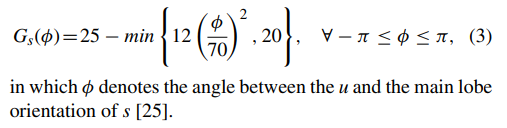

In [266]:
#angle made by user wrt each base station
def UserAngle(mobileuser_x, mobileuser_y, BS_totalx, BS_totaly):
  
  t, user_num = np.shape(mobileuser_x) #time_instant, total_users

  total_bss = len(BS_totalx)

  all_angles = np.zeros((t, total_bss, user_num))
  dx = np.zeros((t, total_bss, user_num))
  dy = np.zeros((t, total_bss, user_num)) 

  for time in range(t):
    for bs in range(total_bss):
      dx[time][bs] = mobileuser_x[time] - BS_totalx[bs]

  for time in range(t):
    for bs in range(total_bss):
      dy[time][bs] = mobileuser_y[time] - BS_totaly[bs]

  
  all_angles = np.arctan2(dy, dx)  #time_instant x base_station x total_users

  return all_angles

In [267]:
#phi calculation
def FindPhi(user_angles):
  user_angles = user_angles*180/math.pi   #radians to degree
  
  t, bs, users = np.shape(user_angles)

  phi = np.zeros((t, bs, users)) #bs = (7*3)*7 = 147 = 49*3

  lobe_angle = np.array([[60,180,-60]*int(bs/3)])
  lobe_angle = lobe_angle.transpose()

  for time in range(t):
    phi[time] = lobe_angle - user_angles[time]


  #phi = lobe_angle - user_angles

  phi = np.where(phi>180, 360-phi, phi)  #convert phi range in -180 to 180 deg i.e., phi = phi>180 ? 360-phi : phi

  return phi*math.pi/180    # degree back to radians


In [268]:
def DirectivityGain(users_phi):
  users_phi = users_phi * 180/math.pi #converts to degree
  dir_gain = 25 - np.minimum(12*np.power(users_phi/70, 2), 20)

  return dir_gain

In [269]:
def AntennaGain(dir_gain):  #ant_gain = k*Direc_gain -> dir_gain(dB) = 10log10(k) + Direc_gain(dB)
  k = 0.5                   #k = antenna efficiency factor
  antenna_gain = 10*math.log10(k) + dir_gain 
  
  return antenna_gain

# **Channel Gain Calculations**

In [270]:
def ChannelGainCalculation(pathloss, shadloss, userangles): #Channel Gain Calculations
    
    users_phi = FindPhi(userangles)
    directivity_gain = DirectivityGain(users_phi)
    
    #channel gain dim -> time_steps x base_stations x users
    
    rchgain = - pathloss + directivity_gain - shadloss
    rchgain_lin = np.power(10, (rchgain)/10) #linear


    return rchgain_lin

# **SINR calculation**

In [271]:
def SINR_b4(channel_gain_matrix):
  #e total transmit power of a BS, Ps = 46dBm
  #dBm to watts
  #Ps = 46dBm--->39.81071706W ---> 10log(39.81071706) = 16dB
  M = 99

  Ps_dbm = 46 #dbm
  
  #dBm TO watts CONVERTER
  Ps_lin = pow(10, (Ps_dbm-30)/10)   #Psdbm is in dBm and Ps_watt in Watts
  Ps_lin = Ps_lin/M

  #watts TO dB CONVERTER
  Ps_dB = 10*math.log10(Ps_lin) #dB

  #calculation in linear then converting to dB
  signal_power_matrix = Ps_lin * channel_gain_matrix[:,0:21, :]


  #NOISE
#------------------------------------------------------------------------------------
  #noise power kTB, kT = -174dBm/Hz, BW = bandwidth       
  #kTB(dBm) = -174 + 10log(BW) 
#------------------------------------------------------------------------------------
  
  noise = -174 + 10*math.log10(180*1000) #dBm         BW = 180KHz                   
  #dBm TO watts CONVERTER
  noise_watt = pow(10, (noise-30)/10)   #noise is in dBm and noise_watt in Watts
  #watts TO dB CONVERTER
  noise_dB = 10*math.log(noise_watt, 10) #dB


  #INTERFERENCE
  interference_matrix = np.zeros(np.shape(channel_gain_matrix[:,0:21, :]))

  intf_time, intf_bs, intf_user = np.shape(interference_matrix)

  total_time, total_base_stations, total_users = np.shape(channel_gain_matrix)

  bs_reference = []

  in_one_cell = total_users#int(total_users/7) #total users in one hex cell

  for k in range(7):
    for i in range(in_one_cell):
      bs_reference.append(k)
  
  bs_reference = np.array(bs_reference)

  #print(np.shape(bs_reference))


  for inft in range(intf_time):
    for bss in range(intf_bs):
      for user in range(intf_user): 
        m = bs_reference[user]
        x_dis = BS_locations_x[m]
        y_dis = BS_locations_y[m]
        for j in range(total_base_stations):
          interference_distance = math.sqrt(pow(x_dis - BS_wrap_around_total3x[j], 2) + pow(y_dis - BS_wrap_around_total3y[j], 2))
          if (j!=bss and  math.floor(interference_distance) <= ISD):
            interference_matrix[inft][bss][user] +=  Ps_lin * channel_gain_matrix[inft][j][user]

 
  #SINR
  interference_plus_noise_matrix = 0.33*interference_matrix + noise_watt

  sinr = signal_power_matrix/interference_plus_noise_matrix  #linear

  sinr_dB = 10*np.log10(sinr) #dBe
  sinr_mean = np.mean(sinr_dB)

  return sinr_dB, signal_power_matrix, interference_plus_noise_matrix


# Predicition for each Model

In [325]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0
        self.P *= 1

    def predict(self, u = 0):
        #print("X: ", self.x)
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
            (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [326]:
def KalmanFilterModel(measurement):
    #dt = 1.0/60
    F = np.array([[1, 0], [0, 1]])
    H = np.array([1, 0]).reshape(1, 2)
    Q = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    R = np.array([0.5]).reshape(1, 1)

    #x = np.linspace(-10, 10, 10)
    #measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 10)

    kf = KalmanFilter(F = F, H = H, R = R)
    predictions = []

    for z in measurement:
        predictions.append(np.dot(H,  kf.predict())[0])
        kf.update(z)
    
    #print(F,'\n\n', H, '\n\n', R,'\n\n' ,Q)
    
    return np.array(predictions)

In [327]:
from tensorflow.keras.models import load_model

In [307]:
def dnnpred(data):
    dnn_model = load_model('saved_models/dnn_with_corrshad6dB_27dec.h5')
    window_size = 30
    dnn_prediction = model_forecast(dnn_model, data[0:-1], window_size=30)
    dnn_prediction = dnn_prediction[:,0]    
    dnn_rmse = mean_squared_error(data[window_size:], dnn_prediction, squared=False)
    dnn_mae = mean_absolute_error(data[window_size:], dnn_prediction)
    
    return dnn_rmse, dnn_mae

In [308]:
def lstmpred(data):
    lstm_model = load_model('saved_models/lstm_norm_correl6dB_all.h5')
    test_dtii = scaler.fit_transform(np.expand_dims(data, axis=1)) # normalized/ min-max scaler
    
    #predictions on normalized set
    testdti_forecast = lstm_model.predict(test_dtii[np.newaxis, :,:]) #, np.newaxis])
    testdti_forecast = testdti_forecast[0,:]
    
    #getting the original values by inverse transform
    testdt_actuali = scaler.inverse_transform(test_dtii) #(5000,1)
    testpred_actuali = scaler.inverse_transform(testdti_forecast) #(5000,1)
    
    lstm_rmse = mean_squared_error(testdt_actuali, testpred_actuali, squared=False)
    lstm_mae = mean_absolute_error(testdt_actuali, testpred_actuali)
    
    return lstm_rmse, lstm_mae

In [309]:
def kfpred(data):
    kf_prediction = KalmanFilterModel(data)
    kf_rmse = mean_squared_error(data, kf_prediction, squared=False)
    kf_mae = mean_absolute_error(data, kf_prediction)
    
    return kf_rmse, kf_mae

In [310]:
def svrpred(data):
    # load the model
    svr_model = pickle.load(open('saved_models/svrmodel_8db.sav', 'rb'))
    window_size = 30
    
    testx, testy = window_dataset(data, window_size)
    test_svr_pred = svr_model.predict(testx)
    
    svr_rmse = mean_squared_error(testy, test_svr_pred, squared= False)
    svr_mae = mean_absolute_error(testy, test_svr_pred)
    
    return svr_rmse, svr_mae

In [311]:
svr_model = pickle.load(open('saved_models/svrmodel_8db.sav', 'rb'))
svr_model

SVR(C=100, epsilon=0.5, gamma=0.001)

In [312]:
gbrt_model = pickle.load(open('saved_models/gbrtmodel_8db.sav', 'rb'))
gbrt_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [313]:
def gbrtpred(data):
    #load the model
    gbrt_model = pickle.load(open('saved_models/gbrtmodel_8db.sav', 'rb'))
    window_size = 30
    
    testx, testy = window_dataset(data, window_size)
    test_svr_pred = gbrt_model.predict(testx)
    
    gbrt_rmse = mean_squared_error(testy, test_svr_pred, squared= False)
    gbrt_mae = mean_absolute_error(testy, test_svr_pred)
    
    return gbrt_rmse, gbrt_mae

In [314]:
def arimapred(data):
    # load model
    #arima_model = ARIMAResults.load('saved_models/arima_model_6db.pkl')
    # walk-forward validation
    training_window = 10

    history = [x for x in data]
    history = history[:training_window]

    predictions = []
    order = (2, 1, 0)
    HORIZON = 1
    
    for t in range(len(data)-training_window):
        model = ARIMA(endog=history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps = HORIZON)
        predictions.append(yhat)
        obs = data[training_window+t]
        # move the training window
        history.append(obs)
        history.pop(0)
        
    predictions_arima = np.array(predictions)
    testy = data[training_window:]
    
    arima_rmse = mean_squared_error(testy, predictions_arima, squared= False)
    arima_mae = mean_absolute_error(testy, predictions_arima)
    
    return arima_rmse, arima_mae

In [315]:
with open("saved_models/hmm_6dB.pkl", "rb") as file: 
    pickle.load(file)

In [316]:
# load the model 
hmm_model = pickle.load(open('saved_models/hmm_6dB.pkl', 'rb'))

In [317]:
hmm_model

GaussianHMM(covariance_type='full', n_components=15, n_iter=1000, tol=0.0001)

In [318]:
def hmmpred(data):
    predicted_data = np.empty([0,1])#dataset.shape[0]])
    likelihood_vect = np.empty([0,1])

    NUM_TEST = len(data)
    window_size = 10
    K = 10
    NUM_ITERS=500
    opt_states = 18
    feat_dataset = data.reshape(-1, 1)
#     for idx in reversed(range(NUM_TEST)):
#         train_dataset = feat_dataset[idx + 1:,:]
#         test_data = feat_dataset[idx,:]
#         num_examples = train_dataset.shape[0]
#         #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
#         if idx == NUM_TEST - 1:
#             model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
#         else:
#             # Retune the model by using the HMM paramters from the previous iterations as the prior
#             model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
#             model.transmat_ = transmat_retune_prior 
#             model.startprob_ = startprob_retune_prior
#             model.means_ = means_retune_prior
#             model.covars_ = covars_retune_prior

#         model.fit(np.flipud(train_dataset))

#         transmat_retune_prior = model.transmat_
#         startprob_retune_prior = model.startprob_
#         means_retune_prior = model.means_
#         covars_retune_prior = model.covars_
        
        
#         #model.monitor_.iter -> No. of iterations performed while training the model
#         if model.monitor_.iter == NUM_ITERS:
#             print('Increase number of iterations')
#             sys.exit(1)
#         #print('Model score : ', model.score(feat_dataset))
#         #print('Dirichlet parameters : ',dirichlet_params)
        
    
    model = hmm_model
    predicted_size = len(data)-window_size
    
    past_likelihood = np.zeros(predicted_size)
    for i in range(0, predicted_size):
        past_likelihood[i] = model.score(feat_dataset[i: i+window_size])
        
    for i in range(window_size, len(data)):
        curr_likelihood = model.score(feat_dataset[i-window_size:i, :])
        if (i==window_size):
            predicted_data = feat_dataset[i-1,:]
        else:
            likelihood_diff_idx = np.argmin(np.absolute(past_likelihood[0:i-window_size] - curr_likelihood))
            predicted_change = feat_dataset[likelihood_diff_idx+window_size-1,:] - feat_dataset[likelihood_diff_idx+window_size,:]
            predicted_data = np.vstack((predicted_data, feat_dataset[i-1,:] + predicted_change))
        
        
#     for i in range(window_size, predicted_size):
#         curr_likelihood = model.score(feat_dataset[i-window_size:i, :])   
#         past_likelihood = []
#         idx = i-1
#         j = 0
#         while j+window_size-1 < idx : 
#             past_likelihood = np.append(past_likelihood, model.score(feat_dataset[j: j+window_size]))
#             j += 1
#         if (i==window_size) :
#             predicted_data = np.vstack((predicted_data, feat_dataset[i-1,:]))
#         else :
#             likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
#             predicted_change = feat_dataset[likelihood_diff_idx,:] - feat_dataset[likelihood_diff_idx + 1,:]
#             predicted_data = np.vstack((predicted_data, feat_dataset[i-1,:] + predicted_change))                

#         iters = 1;
#         past_likelihood = []
#         curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
#         while iters < num_examples / K - 1:
#             past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
#             iters = iters + 1
#         likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
#         predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
#         predicted_data = np.vstack((predicted_data, feat_dataset[idx + 1,:] + predicted_change))
    
    actual_data = feat_dataset[window_size:,:]
    hmm_rmse = mean_squared_error(predicted_data, actual_data,  squared= False)
    hmm_mae = mean_absolute_error(predicted_data, actual_data)
    
    
    return hmm_rmse, hmm_mae, predicted_data, actual_data


1.1891333247108018 0.6737023997716919


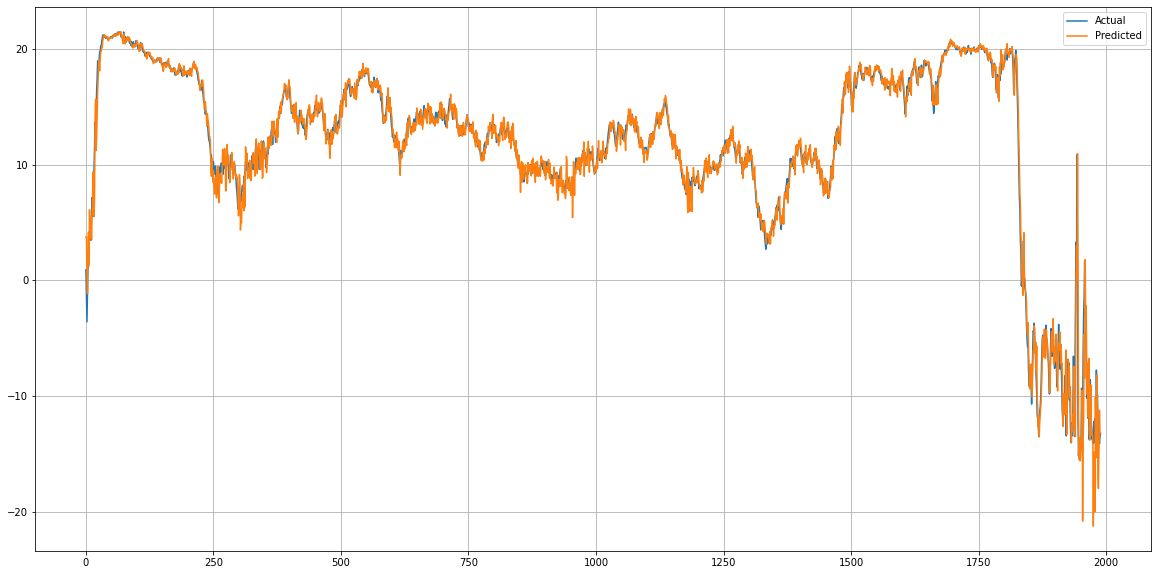

In [319]:
dtt = np.loadtxt('usersinrdataset6dB_10to20mps.csv', delimiter=',')
userdtt = dtt[:,5]
userdtt.shape
hmmrm, hmmae, pr, act = hmmpred(userdtt)
print(hmmrm, hmmae)
plt.figure(figsize=(20, 10))
plt.plot(act, label = 'Actual')
plt.plot(pr, label='Predicted')
plt.grid()
plt.legend()
plt.show()

In [320]:
def transformerpred(data):
    # Loading the saved model
    transformer_model = torch.load('saved_models/transformer_model6dB')
    transformer_model.eval()
    
    data_ = scaler.fit_transform(data.reshape(-1, 1))
    testdata = test_data_to_dataset(data_.flatten(), 10)
    
    test_losses, test_preds  = [], []
    test_true = []
    for (x, y) in testdata:
        #S = x.shape[-2]
        y_pred = transformer_model(x.float())
        loss_test = torch.nn.MSELoss()(y_pred, y)  # (B,S)
        test_losses.append(loss_test.item())
        test_preds.append(y_pred.detach().cpu().numpy())
        test_true.append(y.detach().cpu().numpy())
    test_preds = np.vstack(test_preds)
    test_true = np.vstack(test_true)
    np.mean(test_losses)
    
    predictions = scaler.inverse_transform(test_preds)
    true_value = scaler.inverse_transform(test_true)
    
    tr_rmse = mean_squared_error(predictions, test_true, squared=False)
    tr_mae = mean_absolute_error(true_value, test_true)
    
    return tr_rmse, tr_mae

In [321]:
trmse, tmae = transformerpred(userdtt)

In [322]:
print(trmse, tmae)

8.309833323817926 12.536128370956208


In [332]:
a, b = kfpred(dtt[:, 9])

In [333]:
print(a, b)

0.6116569908504736 0.40853635556109846


In [297]:
# Prediction Function
def PredictSinr(data):
    result_dict = {'dnn': {'rmse': 0, 'mae': 0}, 
                   'lstm': {'rmse': 0, 'mae': 0},
                   'transformer': {'rmse': 0, 'mae': 0},
                   'hmm': {'rmse': 0, 'mae': 0},
                   'kf': {'rmse': 0, 'mae': 0},
                   'svr': {'rmse': 0, 'mae': 0},
                   'gbrt': {'rmse': 0, 'mae': 0},
                   'arima': {'rmse': 0, 'mae': 0},
                  }
    
    result_dict['dnn']['rmse'], result_dict['dnn']['mae'] = dnnpred(data)
    result_dict['lstm']['rmse'], result_dict['lstm']['mae'] = lstmpred(data)
    result_dict['transformer']['rmse'], result_dict['transformer']['mae'] = transformerpred(data)
    result_dict['hmm']['rmse'], result_dict['hmm']['mae'], _, _ = hmmpred(data)
    result_dict['kf']['rmse'], result_dict['kf']['mae'] = kfpred(data)
    result_dict['svr']['rmse'], result_dict['svr']['mae'] = svrpred(data)
    result_dict['gbrt']['rmse'], result_dict['gbrt']['mae'] = gbrtpred(data)
    result_dict['arima']['rmse'], result_dict['arima']['mae'] = math.inf, math.inf #arimapred(data)
    
    return result_dict


# **SIMULATION FUNCTION**

In [209]:
#create results dataframe
l = [0, 0]
results_dict = {'DNN': l, 'LSTM': l, 'Transformer': l, 'KF': l, 'HMM': l, 'SVR': l, 'GBRT': l, 'ARIMA': l}
df = pd.DataFrame(data=results_dict, index=['RMSE', 'MAE'])
alist  = [2.0, 1.4]
df['DNN'] = [x/len(alist) for x in alist]

print(df)

      DNN  LSTM  Transformer  KF  HMM  SVR  GBRT  ARIMA
RMSE  1.0     0            0   0    0    0     0      0
MAE   0.7     0            0   0    0    0     0      0


# **SINR with Shadowing**

In [210]:
def getsinrdataset(nums, each_sec, Time_instants, v_min, v_max, std_dev):#nums = total no.of simulations, each_sec = no. of users in each secto 
    for i in range(nums):
        iteration_num = i
        num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
        #PlotSecUsers(num_users, x, y)

        x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, v_min, v_max, Time_instants) #time_instants x total_users

        #doing calculations only for the centre cell
        num_users = each_sec*3
        x_mobile = x_mobile[:, :num_users]
        y_mobile = y_mobile[:, :num_users]

        dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, Time_instants)

        path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

        shadowing = correlated_shadowing(x_mobile, y_mobile, std_dev)

        angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

        channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

        channel_gain_dB = 10*np.log10(channel_gain_linear)

        Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210
        
        if(i==0):
            sinr_dataset = Sinr_dB[:, 0, 0][np.newaxis, :]
        else:
            sinr_dataset = np.concatenate((sinr_dataset, Sinr_dB[:, 0, 0][np.newaxis, :]), axis=0)
            

        return sinr_dataset

In [211]:
def SINRsimulations(nums, each_sec, Time_instants, v_min, v_max, std_dev, df):  #nums = total no.of simulations, each_sec = no. of users in each sector
    sum_dnn = [0, 0] #rmse, ,mae
    sum_lstm = [0, 0]
    sum_transformer = [0, 0]
    sum_hmm = [0, 0]
    sum_kf = [0, 0]
    sum_arima = [0, 0]
    sum_svr = [0, 0]
    sum_gbrt = [0, 0]
    
    for i in range(nums):
        iteration_num = i
        num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
        #PlotSecUsers(num_users, x, y)

        x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, v_min, v_max, Time_instants) #time_instants x total_users

        #doing calculations only for the centre cell
        num_users = each_sec*3
        x_mobile = x_mobile[:, :num_users]
        y_mobile = y_mobile[:, :num_users]

        dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, Time_instants)

        path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

        shadowing = correlated_shadowing(x_mobile, y_mobile, std_dev)

        angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

        channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

        channel_gain_dB = 10*np.log10(channel_gain_linear)

        Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210(users)
        
        user_sinr = Sinr_dB[:,0,0]
        
        result_dict = PredictSinr(user_sinr)
        
        sum_dnn[0] += result_dict['dnn']['rmse']
        sum_dnn[1] += result_dict['dnn']['mae']
        sum_lstm[0] += result_dict['lstm']['rmse']
        sum_lstm[1] += result_dict['lstm']['mae']
        sum_transformer[0] += result_dict['transformer']['rmse']
        sum_transformer[1] += result_dict['transformer']['mae']
        sum_hmm[0] += result_dict['hmm']['rmse']
        sum_hmm[1] += result_dict['hmm']['mae']
        sum_kf[0] += result_dict['kf']['rmse']
        sum_kf[1] += result_dict['kf']['mae']
        sum_svr[0] += result_dict['svr']['rmse']
        sum_svr[1] += result_dict['svr']['mae']
        sum_arima[0] += result_dict['arima']['rmse']
        sum_arima[1] += result_dict['arima']['mae']
        sum_gbrt[0] += result_dict['gbrt']['rmse']
        sum_gbrt[1] += result_dict['gbrt']['mae']
    
    df['DNN'] = [x/nums for x in sum_dnn]
    df['LSTM'] = [x/nums for x in sum_lstm]
    df['Transformer'] = [x/nums for x in sum_transformer]
    df['HMM'] = [x/nums for x in sum_hmm]    
    df['KF'] = [x/nums for x in sum_kf]    
    df['SVR'] = [x/nums for x in sum_svr]
    df['GBRT'] = [x/nums for x in sum_gbrt]
    df['ARIMA'] = [x/nums for x in sum_arima]    
    
    
    return df

In [212]:
# Function to run simulations -> it returns the RMSE, MAE values for all models in the form of a csv file
# this csv file stores results for each experiment we are performing -> eg. fixed std dev, variable speed and vice versa

class SIM():
    def __init__(self, num, total_time_steps, std_dev, v_min, v_max):
        self.num = num
        self.total_time_steps = total_time_steps
        self.std_dev = std_dev
        self.v_min = v_min
        self.v_max = v_max
        
    def RunSimulations(self, each_sec = 2):
        #create results dataframe
        l = [0, 0]
        results_dict = {'DNN': l, 'LSTM': l, 'Transformer': l, 'KF': l, 'HMM': l, 'SVR': l, 'GBRT': l, 'ARIMA': l}
        df = pd.DataFrame(data=results_dict, index=['RMSE', 'MAE'])

        start = time.time()
        exp_result = SINRsimulations(self.num, each_sec, self.total_time_steps, self.v_min, self.v_max, self.std_dev, df)
        end = time.time()
        
        print(f'Time taken: {(end-start)/60} mins')

        exp_result.to_csv(f'model_results/simulationresult_{std_dev}db_{v_min}to{v_max}mps.csv')

        return exp_result
        
    def getsinrdataset(self, each_sec=2):#nums = total no.of simulations, each_sec = no. of users in each secto 
        for i in range(self.num):
            iteration_num = i
            num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
            #PlotSecUsers(num_users, x, y)

            x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, self.v_min, self.v_max, self.total_time_steps) #time_instants x total_users

            #doing calculations only for the centre cell
            num_users = each_sec*3
            x_mobile = x_mobile[:, :num_users]
            y_mobile = y_mobile[:, :num_users]

            dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, self.total_time_steps)

            path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

            shadowing = correlated_shadowing(x_mobile, y_mobile, self.std_dev)

            angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

            channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

            channel_gain_dB = 10*np.log10(channel_gain_linear)

            Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210

            if(i==0):
                sinr_dataset = Sinr_dB[:, 0, 0][np.newaxis, :]
            else:
                sinr_dataset = np.concatenate((sinr_dataset, Sinr_dB[:, 0, 0][np.newaxis, :]), axis=0)
            
            print(sinr_dataset.shape)

        return sinr_dataset


In [213]:
#result = RunSimulations(num, total_time_steps, std_dev, v_min, v_max)

In [228]:
pwd

'/home/vaibhav/Documents/MTech Project/SINR PREDICTION WORK/SINR_simulations'

In [340]:
#Object of the class sim
iterations = 10
timesteps = 1000
std_dev = 6 #dB
v_min = 20 #m/s
v_max = 30 #m/s

sim = SIM(iterations, timesteps, std_dev, v_min, v_max)


In [338]:
testdf = sim.RunSimulations()

Time taken: 4.955260034402212 mins


In [339]:
testdf

,DNN,LSTM,Transformer,KF,HMM,SVR,GBRT,ARIMA
RMSE,1.101847,4.707902,5.342725,1.184485,1.601389,1.412701,1.270954,inf
MAE,0.884338,3.017382,10.687042,0.897450,1.221161,1.034160,1.004791,inf


In [341]:
start = time.time()
user_dataset = sim.getsinrdataset()
print(f'Time taken: {(time.time()-start)/60} mins')

(1, 1000)
(2, 1000)
(3, 1000)
(4, 1000)
(5, 1000)
(6, 1000)
(7, 1000)
(8, 1000)
(9, 1000)
(10, 1000)
Time taken: 4.258039661248525 mins


In [342]:
usds = np.transpose(user_dataset)
print(usds.shape)

(1000, 10)


In [343]:
np.savetxt(f'usersinrdataset{std_dev}dB_{v_min}to{v_max}mps.csv', usds, delimiter=',')

In [ ]:
# for i in range(iterations):
#     plt.plot(user_dataset[i])
#     plt.show()